# CAISO LMP Price Extraction

<b>Author:</b> Neal Ma

<b>Date:</b>October 6, 2024

<b>Description:</b> This notebook shows how to extract local marginal price (LMP) data from CAISO's OASIS API (https://www.caiso.com/Documents/OASIS-Frequently-Asked-Questions.pdf) and saves data to parquet file for easy storage and access.

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import pyarrow as pa
import pyarrow.parquet as pq
import zipfile
import time
import matplotlib.pyplot as plt

In [2]:
START_DATE = "2021-06-15"
END_DATE = "today"

DATA_DOWNLOAD = False

BASEURL = "http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_INTVL_LMP"
VERSION = "2"
MARKET = "RTM"  # "DAM" for day-ahead market

NODES = ["MEADS_2_N101"]
TIMEZONE = "US/Pacific"  # see https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568

CSV_STORAGE_PATH = "./data/LMP_CSV"
LMP_STORAGE_PATH = "./data/LMP"

In [3]:
# build the directory to store CSV files
if not os.path.exists(CSV_STORAGE_PATH):
    os.makedirs(CSV_STORAGE_PATH)

# build the directory to store the LMP table
if not os.path.exists(LMP_STORAGE_PATH):
    os.makedirs(LMP_STORAGE_PATH)

In [4]:
# only 31 days of data can be accessed at once so we iterate through every 15 days
timeseries = pd.date_range(
    start=pd.Timestamp(START_DATE), end=pd.Timestamp(END_DATE), freq="15D", tz=TIMEZONE
)


def format_datetime_str(ts: pd.Timestamp = None):
    # to deal with the '-' in the string format of the timezone
    temp_str = ts.strftime("%Y%m%dT%:z-0000").split("T")
    temp_str[1] = temp_str[1][1:]
    return "T".join(temp_str)

In [5]:
if DATA_DOWNLOAD:
    for idx in range(len(timeseries) - 1):

        url = BASEURL
        url += f"&startdatetime={format_datetime_str(timeseries[idx])}"
        url += f"&enddatetime={format_datetime_str(timeseries[idx+1])}"
        url += f"&version={VERSION}"
        url += f"&resultformat=6"
        url += f"&market_run_id={MARKET}"
        url += f"&node={','.join(NODES)}"

        response = requests.get(url)
        zip_path = os.path.join(CSV_STORAGE_PATH, f"data.zip")
        print(url)

        # Save the zip file
        with open(zip_path, "wb") as f:
            f.write(response.content)
        # Extract the csv file from the zip
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(CSV_STORAGE_PATH)

        # Delete the .zip file
        os.remove(zip_path)

        # Reduce request speed to avoid rate limits
        time.sleep(2)

In [6]:
# parquet save file path
parquet_path = os.path.join(
    LMP_STORAGE_PATH, f'{"_".join(NODES)}_{MARKET}_DATA.parquet'
)

if DATA_DOWNLOAD:
    # Read all CSV files in the directory
    all_files = [
        os.path.join(CSV_STORAGE_PATH, f)
        for f in os.listdir(CSV_STORAGE_PATH)
        if f.endswith(".csv")
    ]

    # Concatenate all CSV files into a single DataFrame
    df_list = [pd.read_csv(file) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)

    # Remove duplicate rows
    combined_df.drop_duplicates(inplace=True)

    # Sort by 'INTERVALSTARTTIME_GMT'
    combined_df.sort_values(by="INTERVALSTARTTIME_GMT", inplace=True)

    # Save to a Parquet file
    # combined_df.to_parquet(parquet_path, engine='pyarrow', index=False) # NOTE: Uncomment to write to parquet file
else:
    # Load the parquet file into a DataFrame
    df_parquet = pd.read_parquet(
        parquet_path, engine="pyarrow"
    )  # NOTE: Uncomment to read from parquet file

# Display the first few rows of the DataFrame
df_parquet.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,VALUE,OPR_INTERVAL,GROUP
0,2021-06-24T07:00:00-00:00,2021-06-24T07:05:00-00:00,2021-06-24,1,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,RTM,MCC,LMP_CONG_PRC,MEADS_2_N101,ALL,1,0.00000,1,1
1,2021-06-24T07:00:00-00:00,2021-06-24T07:05:00-00:00,2021-06-24,1,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,RTM,MCL,LMP_LOSS_PRC,MEADS_2_N101,ALL,1,0.02259,1,4
2,2021-06-24T07:00:00-00:00,2021-06-24T07:05:00-00:00,2021-06-24,1,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,RTM,MGHG,LMP_GHG_PRC,MEADS_2_N101,ALL,1,0.00000,1,3
3,2021-06-24T07:00:00-00:00,2021-06-24T07:05:00-00:00,2021-06-24,1,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,RTM,LMP,LMP_PRC,MEADS_2_N101,ALL,1,37.67775,1,5
4,2021-06-24T07:00:00-00:00,2021-06-24T07:05:00-00:00,2021-06-24,1,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,RTM,MCE,LMP_ENE_PRC,MEADS_2_N101,ALL,1,37.65516,1,2


Index(['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT', 'OPR_DT', 'OPR_HR',
       'NODE_ID_XML', 'NODE_ID', 'NODE', 'MARKET_RUN_ID', 'LMP_TYPE',
       'XML_DATA_ITEM', 'PNODE_RESMRID', 'GRP_TYPE', 'POS', 'VALUE',
       'OPR_INTERVAL', 'GROUP'],
      dtype='object')


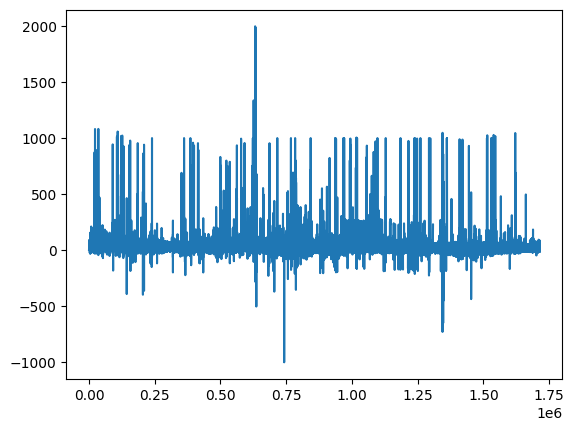

In [9]:
plt.plot(df_parquet['VALUE'])
print(df_parquet.columns)

In [11]:
print(df_parquet.INTERVALSTARTTIME_GMT[np.argmax(df_parquet.VALUE)])
print(df_parquet.VALUE[np.argmax(df_parquet.VALUE)])

2022-09-06T02:25:00-00:00
1999.2565
